Import basic packages

In [1]:
#
import os
import tarfile
import urllib
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import numpy as np

import hashlib

import sklearn
from sklearn.utils import check_array
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from scipy import sparse

In [2]:
#
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# Download data

Run next cell to creat a HOUSING_URL for downloading data

In [3]:
#
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

Create a relative system path datasets\housing, and name it as HOUSING_PATH

In [4]:
HOUSING_PATH = os.path.join('datasets', 'housing')

Define a function of fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH). 

This function would:
1. Check the existence of housing_path in system. If not existing, create this path.
2. download the tgz file from housing_url
3. Extract the tgz file to housing_path

In [5]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # 1
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    # 2
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, filename=tgz_path)
    
    # 3
    tgz_file = tarfile.open(tgz_path)
    tgz_file.extractall(housing_path)
    tgz_file.close()
    

Now run fetch_housing_data to extract the csv file

In [6]:
fetch_housing_data()

Now define a function load_housing_data(housing_path=HOUSING_PATH), which would:
1. Load housing.csv
2. Return a dataframe

In [7]:
csv_path = os.path.join(HOUSING_PATH, 'housing.csv')

In [8]:
csv_path

'datasets/housing/housing.csv'

In [9]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH, 'housing.csv')
    df = pd.read_csv(csv_path)
    return df

Run load_housing_data to create a dataframe 'housing'. Show the head

In [10]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Show the info of housing to see data type, non-null data count, memory usuage, etc

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Show the counts of unique values in ocean_proximity

In [12]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Show the stats of the numerical attributes

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot the histograms of all numerical attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c339bd7b8>,
      dtype=object)

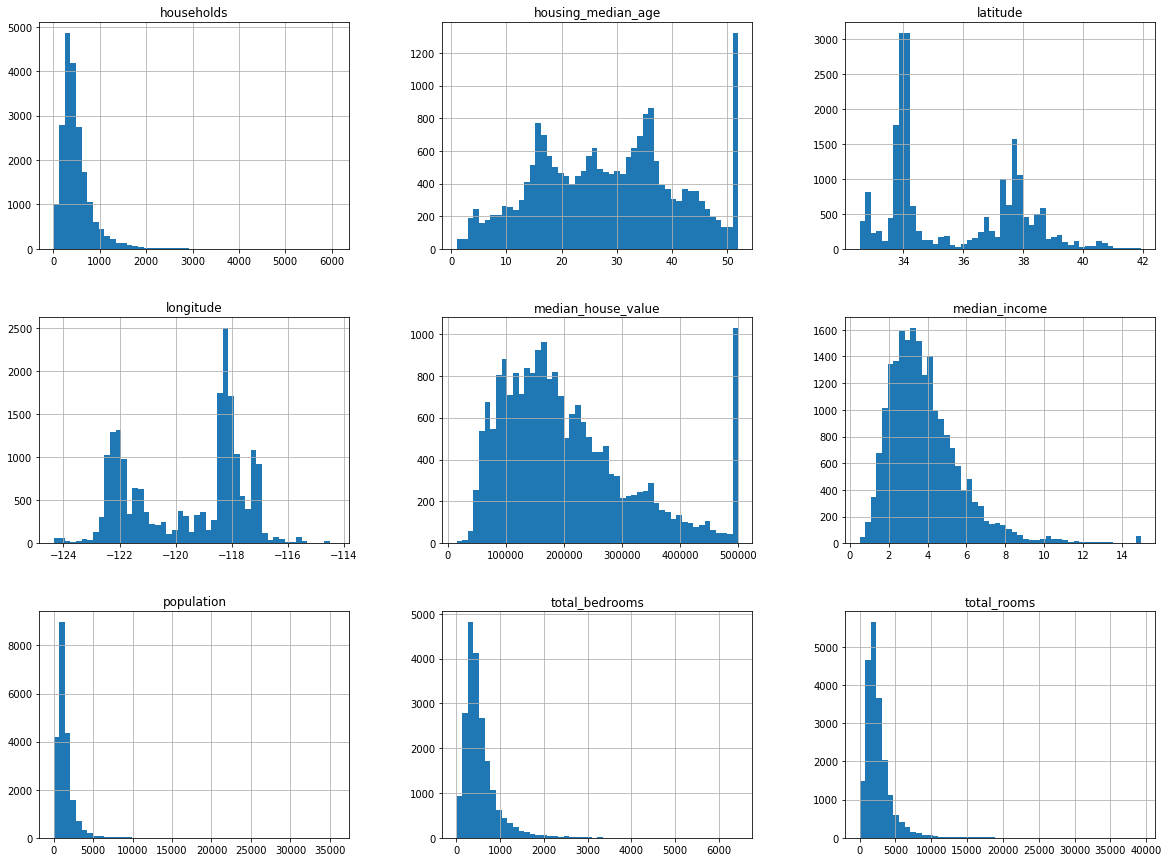

In [14]:
housing.hist(figsize=(20, 15), bins=50)

# Create a test set
Here we set aside a test set. We do this before making any decision to avoid data snooping bias

Define a function split_train_test(dataframe, test_ratio) to split a dataframe to train_set and test_set

In [15]:
def split_train_test(dataframe, test_ratio):
    idx = np.random.permutation(len(dataframe))
    dataframe = dataframe.iloc[idx]
    n_test = int(len(dataframe) * test_ratio)
    test_set = dataframe.iloc[idx[:n_test]]
    train_set = dataframe.iloc[idx[n_test:]]
    return train_set, test_set

Now run the function above to split housing at test_ratio=0.2. To ensure same test data in repeated run of the code, set seed at 42.

In [16]:
np.random.seed=42
train_set, test_set = split_train_test(housing, 0.2)

Instead of define your own function, you can use sklearn.model_selection.train_test_split to split housing to train and test sets. Now try it at test_ratio 0.2.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2)

Up to now we are using purely random sampling. But it is still possible to get sampling bias. For example, we may get too many instances of higher income. Now let us try stratified sampling, which would:
1. Select a key attribute
2. Divide this key attribute into several categories
3. Randomly sample within each category
By doing this, we ensure a representative sampling for each category of the key attribute.

We assume that the median income is the key attribute. Now draw the histogram of median_income

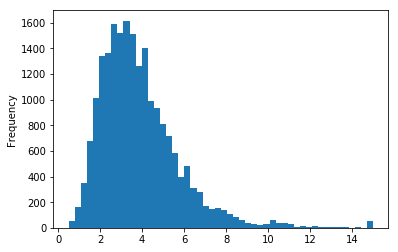

In [19]:
housing.median_income.plot(kind='hist', bins=50)

Now we define a new attribute "incom_cat" to housing: incom_cat = max(5, ceil(housing.median_income))

In [20]:
housing['incom_cat'] = np.ceil(housing.median_income/1.5)

In [21]:
housing['incom_cat'].where(housing['incom_cat']<=5, 5, inplace=True)

Now plot the histogram of incomcat, and count the number of each incom_cat value

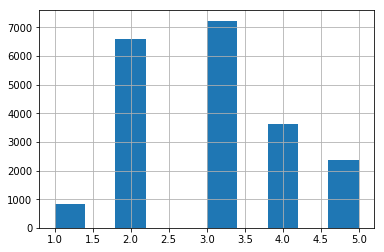

In [22]:
housing['incom_cat'].hist()

In [23]:
housing['incom_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: incom_cat, dtype: int64

Now use StratifiedShuffleSplit to split housing to strat_train_set and strat_test_set data. Note that the stratification is regarding the incom_cat attribute

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

In [25]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [26]:
ii = 0
for train_index, test_index in split.split(housing, housing['incom_cat']):
    strat_train_set = housing.iloc[train_index]
    strat_test_set  = housing.iloc[test_index]

Now compute the proportions of each category of incom_cat in housing and strat_test_set. Check consistence of the proportions.

In [27]:
housing['incom_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: incom_cat, dtype: float64

In [28]:
strat_train_set['incom_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: incom_cat, dtype: float64

Now drop the column of incom_cat from strat_train_set and strat_test_set

In [29]:
strat_train_set.drop(columns=['incom_cat'], axis=1, inplace=True)

/home/chris/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
strat_test_set.drop(columns='incom_cat', axis=1, inplace=True)

/home/chris/ml/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Discover and visualize the data to gain insights

Create dataframe housing as a copy of strat_train_set

In [31]:
housing = strat_train_set.copy()

Create a scatter plot of longitude vs. latitude, and set alpha at 0.1

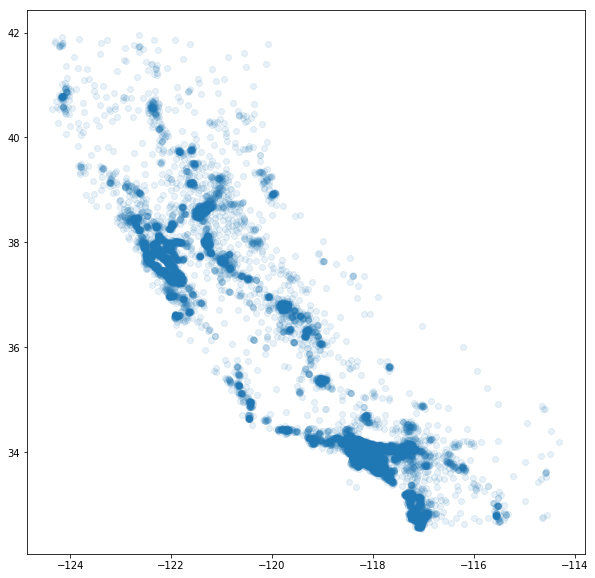

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(housing.longitude, housing.latitude, alpha=0.1)

Now plot the scatter above again, but:
1. Use population/100 as the scatter size
2. Use median_house_value as color
3. Use jet as colormap
4. Set alpha at 0.4
5. Set legend as "Population"
6. Display the color bar

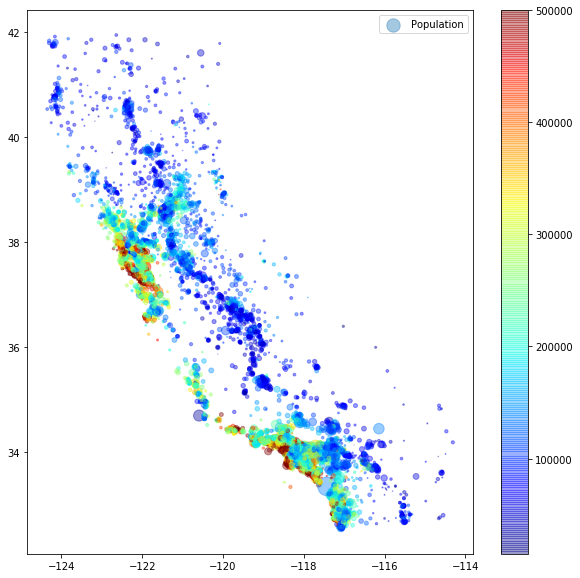

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = ax.scatter(x=housing.longitude, y=housing.latitude,\
          s=housing.population/100, c=housing.median_house_value,\
          alpha=0.4, label='Population', \
          cmap=plt.cm.jet)
ax.legend()
plt.colorbar(sc)

Compute the correlation matrix of housing. Then display the correlation between median_house_value and other attributes in descending order.

In [34]:
corr_matrix = housing.corr()

In [35]:
corr = corr_matrix["median_house_value"].sort_values(ascending=False)
corr

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Now plot the scatter matrix of top 4 attributes in last question.

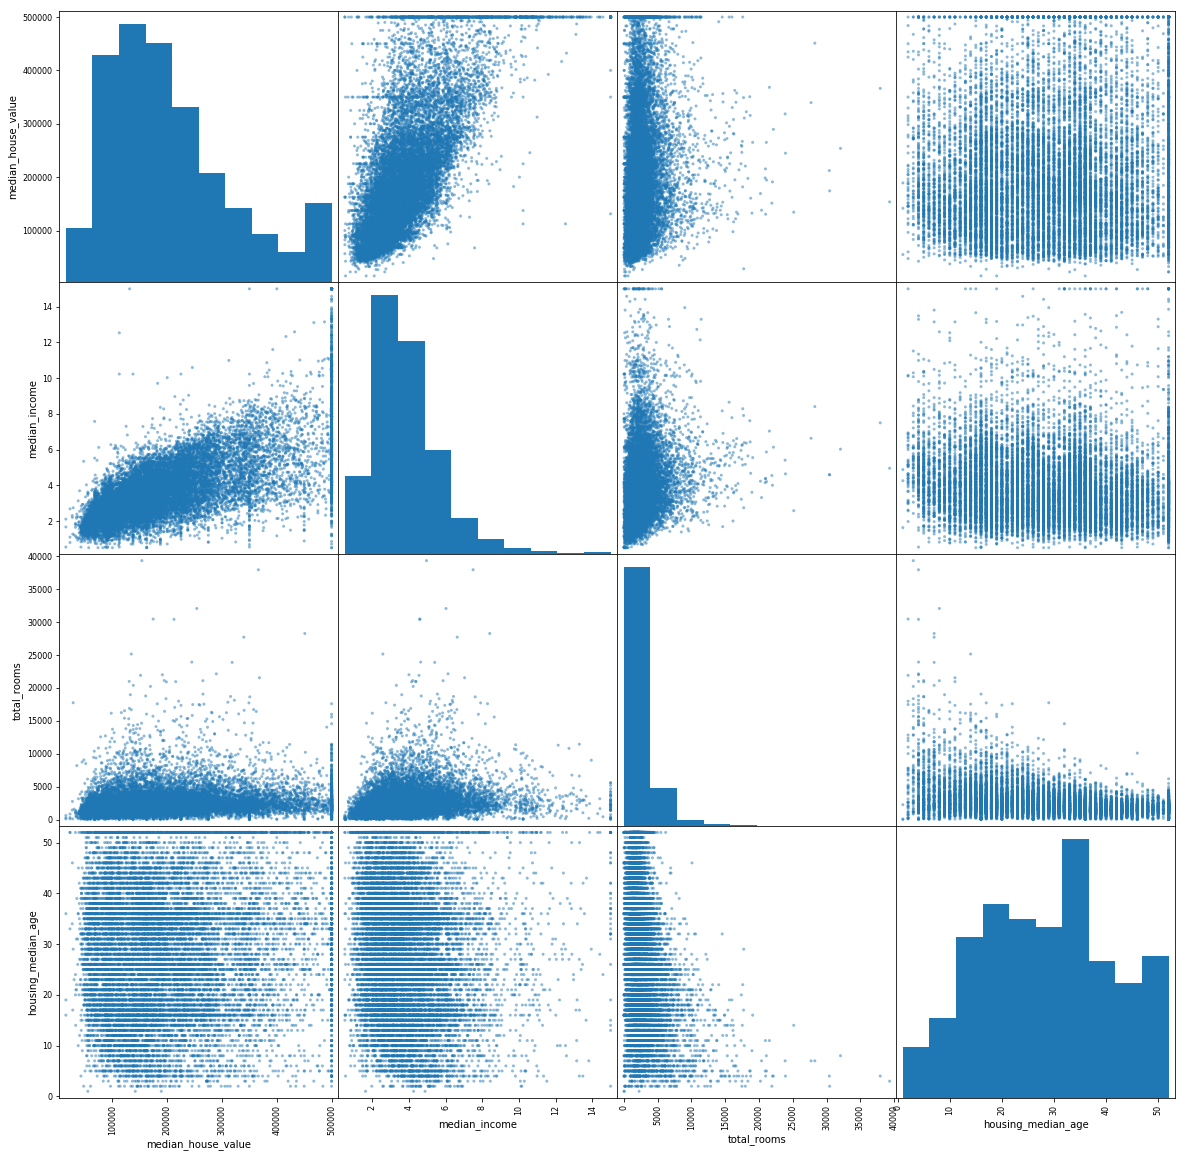

In [36]:
_ = pd.plotting.scatter_matrix(housing[corr.index[:4]], figsize=(20, 20))

Now plot the scatter of median_house_value vs. median_income, the most promising attribute

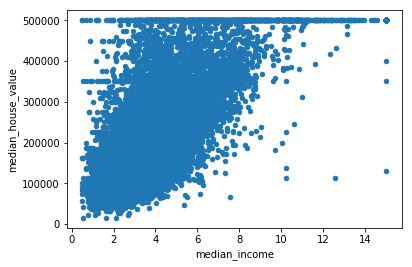

In [37]:
housing.plot(kind='scatter', x='median_income', y='median_house_value')

Now let's try to create some new attributes and add them to housing:
1. rooms_per_househoold;
2. bedrooms_per_room;
3. population_per_household;

In [38]:
housing['rooms_per_household'] = housing.total_rooms / housing.households
housing['bedrooms_per_room'] = housing.total_bedrooms / housing.households
housing['population_per_household'] = housing.population / housing.households

In [39]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,1.035398,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.955752,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,1.019481,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,1.050992,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,1.042379,3.047847


Now calculate the correlation between median_house_value and others again. You should find that the new attribute rooms_per_household and bedrooms_per_room has strong correlation with median_house_value.

In [40]:
corr_m = housing.corr()['median_house_value']
corr_m.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
bedrooms_per_room          -0.043343
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

# Prepare the data for machine learning algorithms

Recreate dataframe housing by droping "median_house_value" from strat_train_set. Create housing_label as the "median_house_value".

In [41]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_label = strat_train_set['median_house_value'].copy()

In [42]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN


In [43]:
housing_label = housing_label.values

Create housing_num by dropping the non-numerical column from housing

In [44]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [45]:
housing_num.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621


Use sklearn to fill missing values in housing_num at attribute median. Return the result as housing_tr

In [46]:
from sklearn.preprocessing import Imputer

In [47]:
imputer = Imputer(strategy='median')

In [48]:
housing_tr = pd.DataFrame(imputer.fit_transform(housing_num), columns=housing_num.columns)

Now let us handle the categorical attribute 'ocean_proximity'. We convert it from text to number by LabelEncoder, and return the result as house_cat_encoded

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
encoder = LabelEncoder()

In [51]:
house_cat_encoded = encoder.fit_transform(housing['ocean_proximity'])

In [52]:
house_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

One problem with the last method is that ML algorithms assume that two nearby values are more similar. But it is not the case for this project. A common solution is to create biniary attribute per category (one-hot). Now use OneHotEncoder to convert housing_cat_encoded and return the result as housing_cat_1hot

In [53]:
from sklearn.preprocessing import OneHotEncoder

In [54]:
oneHotEncoder = OneHotEncoder()

In [55]:
house_cat_1hot = oneHotEncoder.fit_transform(house_cat_encoded[:, np.newaxis])

Now let's assembly a tranformation pipeline. First run next cell to define some idx used later

In [56]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

Then, define your own estimator "CombinedAttributesAdder". This class would:
1. Has a hyperparameter add_bedrooms_per_room with default value True;
2. Has a fit method but do nothing since we don't change the hyperparameter;
3. Has a transform method that 1) take housing.values as input; 2) add rooms_per_household and population_per_household; 3) If add_bedrooms_per_room is true, also add bedroom_per_room. Here you can use the idx defined earlier

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

In [58]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Try to use the fit_transform method of CombinedAttributesAdder to tranform housing and return housing_extra_attribs, which is numpy array. Set add_bedrooms_per_room as False.

In [59]:
converter = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = converter.fit_transform(housing.values)

Scikit-Learn does not take dataframe as input. So it is necessary to define another transformer "DataFrameSelector" to convert housing to numpy array. This transfomer should take a hyperparameter of a list of column names of interest.

In [60]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column].values

Now apply DataFrameSelector to numerical attributes and categorical attributes.

In [61]:
num_column = list(housing_num.columns)
num_selector = DataFrameSelector(column=num_column)
cat_column = [housing.columns[-1]]
cat_selector = DataFrameSelector(column=cat_column)

In [62]:
X_num = num_selector.fit_transform(housing)
X_cat = cat_selector.fit_transform(housing)

Now define a tranformation pipeline "num_pipeline" of 4 components to transform housing_num:
1. selector: DataFrameSelector
2. imputer: Imputer to fill missing values at attribute mean
3. attribs_adder: CombinedAttributesAdder to add only two attributes
4. std_scaler: StandardScaler

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [64]:
num_pipeline = Pipeline([('Selector', DataFrameSelector(list(housing_num.columns))),\
                         ('Imputer', Imputer(strategy='median')),\
                         ('AttribAdder', CombinedAttributesAdder(add_bedrooms_per_room=False)), \
                         ('Normalizer', StandardScaler())])

Now apply fit_transform method of num_pipeline to housing

In [65]:
housing_num_prepared = num_pipeline.fit_transform(housing)

In [66]:
housing_num_prepared.shape

(16512, 10)

Now define the cat_pipeline of two components:
1. DataFrameSelector
2. CategoricalEncoder with encodeing='onehot-dense'

In [67]:
cat_pipeline = Pipeline([('Selector', DataFrameSelector([housing.columns[-1]])), \
                         ('Encoder', CategoricalEncoder(encoding='onehot-dense'))])

We can use FeatureUnion to merge the two pipelines above

In [68]:
from sklearn.pipeline import FeatureUnion

In [69]:
merged_pipeline = FeatureUnion([('num', num_pipeline), ('cat', cat_pipeline)])

Apply this full_pipe to housing the return the result as housing_prepared

In [70]:
housing_prepared = merged_pipeline.fit_transform(housing)

# Select and Train a Model

Create and fit a linear regression model "lin_reg" using housing_prepared and housing_label

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
lin_reg = LinearRegression()

In [73]:
lin_reg.fit(housing_prepared, housing_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now use this model to predict housing.iloc[:5]. Note that you should tranform the data before the prediction. Print out the prediction and the true answers

In [74]:
lin_reg.predict(merged_pipeline.transform(housing.iloc[:5]))

array([211888.26540421, 321274.25149998, 210853.46010112,  62261.10820843,
       194921.76527689])

Now let's measure this regression model's RMSE on the whole training set.

In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
housing_pred = lin_reg.predict(housing_prepared)

In [77]:
RMSE = np.sqrt(mean_squared_error(housing_pred, housing_label))

In [78]:
RMSE

68911.7605423384

The RMSE is quite big compared to house value. This is an example of under fitting. Now let's a more powerful model of DecesionTreeRegressor. Then re-calculate the RMSE.

In [79]:
from sklearn.tree import DecisionTreeRegressor

In [80]:
tree_reg = DecisionTreeRegressor()

In [81]:
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [82]:
housing_pred_tree = tree_reg.predict(housing_prepared)
RMSE_tree = np.sqrt(mean_squared_error(housing_pred_tree, housing_label))
RMSE_tree

0.0

It's like the tree model overfits the model. A better way to evaluate the model is to use cross validation. Now use cross validation to compute the 'neg_mean_squared_error' of each itration (fold). (http://scikit-learn.org/stable/modules/model_evaluation.html)

In [83]:
from sklearn.model_selection import cross_val_score

In [84]:
cv_score = cross_val_score(tree_reg, X=housing_prepared, y=housing_label, scoring='neg_mean_squared_error', cv=5)

Now print out
1. The RMSE of each iteration
2. The mean value of RMSE
3. The std of RMSE
You can define a function to do this

In [85]:
RMSE_cv = np.sqrt(-cv_score)

In [86]:
print('RMSE: ', RMSE_cv.astype(np.int32))
print('Mean of RMSE: {:.0f}'.format(np.mean(RMSE_cv)))
print('Std of RMSE: {:.0f}'.format(np.std(RMSE_cv)))

RMSE:  [68235 68936 74642 69839 74208]
Mean of RMSE: 71173
Std of RMSE: 2708


Look at the score you can find that the decision tree is overfitting so badly. Now let us try random forest regressor. Display the training RMSE score over all training data. Also display the score, score mean, and score std from cross validation.

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [88]:
forest_reg = RandomForestRegressor()

In [89]:
forest_reg.fit(housing_prepared, housing_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [90]:
forest_pred = forest_reg.predict(housing_prepared)
RMSE_forest = np.sqrt(mean_squared_error(forest_pred, housing_label))
print(RMSE_forest.astype(np.int32))

22196


In [91]:
cv_score = cross_val_score(forest_reg, X=housing_prepared, y=housing_label, scoring='neg_mean_squared_error', cv=5)

In [92]:
RMSE_cv = np.sqrt(-cv_score)

In [93]:
print('RMSE: ', RMSE_cv.astype(np.int32))
print('Mean of RMSE: {:.0f}'.format(np.mean(RMSE_cv)))
print('Std of RMSE: {:.0f}'.format(np.std(RMSE_cv)))

RMSE:  [51735 54133 54770 51477 53758]
Mean of RMSE: 53175
Std of RMSE: 1323


Note that random forest is doing better. The training RMSE is much lower than the validation RMSE, so the model is still overfitted.

# Fine-Tune Your Model 

Run the next cell to establish two grid regions.

In [94]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

Use grid search to search the best hyper-parameters of random forest regression.

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
grid_searcher = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', cv=3)

In [97]:
grid_searcher.fit(housing_prepared, housing_label)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'n_estimators': [3, 10], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Show the best estimator and best parameters

In [98]:
grid_searcher.best_params_

{'max_features': 6, 'n_estimators': 30}

Print out the cross validation errors in each step of grid search

In [99]:
cv_result = grid_searcher.cv_results_

In [100]:
cv_result.keys()

dict_keys(['std_train_score', 'param_n_estimators', 'split2_train_score', 'mean_score_time', 'split0_train_score', 'split0_test_score', 'std_test_score', 'split1_test_score', 'mean_test_score', 'std_score_time', 'params', 'param_bootstrap', 'mean_fit_time', 'mean_train_score', 'std_fit_time', 'split1_train_score', 'rank_test_score', 'param_max_features', 'split2_test_score'])

In [101]:
for mean_score, params in zip(cv_result['mean_test_score'], cv_result['params']):
    print(np.sqrt(-mean_score), params)

63066.56314153891 {'max_features': 2, 'n_estimators': 3}
56290.65857125867 {'max_features': 2, 'n_estimators': 10}
53270.63598572745 {'max_features': 2, 'n_estimators': 30}
60586.19322297072 {'max_features': 4, 'n_estimators': 3}
52991.20234403385 {'max_features': 4, 'n_estimators': 10}
50926.86421529492 {'max_features': 4, 'n_estimators': 30}
59776.11637692926 {'max_features': 6, 'n_estimators': 3}
52263.11311397755 {'max_features': 6, 'n_estimators': 10}
50048.91795022668 {'max_features': 6, 'n_estimators': 30}
58584.43086314811 {'max_features': 8, 'n_estimators': 3}
52430.23060457705 {'max_features': 8, 'n_estimators': 10}
50589.418259056096 {'max_features': 8, 'n_estimators': 30}
63343.06658323774 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
55184.50600133564 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
59881.1209821255 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
52448.34619293758 {'max_features': 3, 'n_estimators': 10, 'bootstrap': False

Show the feature importance of the best model.

In [102]:
feature_importance = grid_searcher.best_estimator_.feature_importances_
feature_importance

array([8.15747824e-02, 8.02400982e-02, 4.13625154e-02, 2.07736866e-02,
       1.93507129e-02, 1.93148209e-02, 1.70939007e-02, 3.56966609e-01,
       7.75354571e-02, 1.11601785e-01, 1.02754491e-02, 1.56199268e-01,
       1.07424171e-04, 3.46806170e-03, 4.13542863e-03])

Now you can evaluate your best model in test data. Print out the RMSE on test data.

In [103]:
final_model = grid_searcher.best_estimator_

In [104]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [105]:
y_test = y_test.values

In [106]:
X_test_prepared = merged_pipeline.transform(X_test)

In [107]:
final_predictions = final_model.predict(X_test_prepared)

In [108]:
final_mse = mean_squared_error(final_predictions, y_test)

In [109]:
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47372.415539514084
